# Домашняя работа по кластеризации Борисова Алексея из 201 группы.

In [ ]:
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [1518]:
# Функция выбора центройда для инициализации методом k-means++
def furthest_sample(centers, X):
    Dist = np.min(distance.cdist(centers, X)**2, axis=0)
    Sum = Dist.sum()
    Rnd = np.random.random() * Sum
    cur_sum = 0
    i = -1
    while cur_sum <= Rnd:
        cur_sum += Dist[i]
        i += 1
    return X[i]

# Функция вычисляющее cумму средних внутрикластерных расстояний 
def inner_dist(X, centers, cluster):
    sum = 0
    for i in range(centers.shape[0]):
        Dist = distance.cdist(X[cluster == i], centers[i][np.newaxis,:])**2
        if Dist.shape[0] == 0:
            return np.inf
        sum += Dist.mean()
    return sum

# Функция вычисляющая среднее межкластерное расстояние
def between_dist(X, centers):
    all_center = X.mean(axis=0)
    return 1 / centers.shape[0] *(distance.cdist(centers, all_center[np.newaxis,:])**2).sum()

# Функционал качества, который будем минимизировать
# при поиске оптимального числа кластеров
def Q(X, centers, cluster):
    between = between_dist(X, centers)
    if between == 0:
        return np.inf
    return inner_dist(X, centers, cluster) / between


class MyKMeans:
    
    # Если число кластеров не задано или задано равным 0, 
    # то алгоритм сам его подберёт.
    def __init__(self, n_clusters=0, init='random'):
        self.n_clusters = n_clusters
        self.init = init
        
    def fit_predict(self, X):
        # случай заранее заданного числа кластеров
        if self.n_clusters != 0:
            return self.predict(X, self.n_clusters)
        # будем подбирать оптимальное число кластеров самостоятельно
        n_clusters = 1
        prev_Q = np.inf
        # Даже используя способ инициализации k-means++ 
        # первый центр выбирается случайно,
        # чтобы нивелировать эту случайность будем брать
        # среднее значение функционала качества
        # за некторое количество испытаний, например, 50.
        Q = np.zeros(50)
        while True:
            for j in range(50):
                pred = self.predict(X, n_clusters)
                Q[j] = pred[2]
            cur_Q = Q.mean()
            # Если Функционал качества при n кластерах оказался больше,
            # чем при n-1, то останавливаемся
            if cur_Q > prev_Q: 
                return (cluster, it, prev_Q, diff, centers)
            cluster = pred[0]
            it = pred[1]
            prev_Q = cur_Q
            diff = pred[3]
            centers = pred[4]
            n_clusters += 1
            
    #Метод разбивающий выборку на заранее заданное число кластеров 
    def predict(self, X, n_clusters):
        n_samples = X.shape[0]
        n_features = X.shape[1]
        cluster = np.zeros(n_samples)
        if self.init == 'random':
            centers = X[np.random.choice(n_samples, n_clusters, replace=False)].astype(float)
        elif self.init == 'k-means++':
            arg = np.random.choice(n_samples, 1)
            centers = X[arg]
            for i in range(n_clusters - 1):
                centers = np.vstack((centers, furthest_sample(centers, X)))
        differences = [] # массив хранящий на сколько на каждой итерации сдвинулись центры
        dif = 1 # переменная для подсчета на сколько сдвинулись центры на итерации
        it = 0 # счетчик итераций
        while dif != 0:
            it += 1
            dif = 0
            for i in range(n_samples):
                cluster[i] = np.argmin(distance.cdist(X[i][np.newaxis,:], centers).ravel())
            for i in range(n_clusters):
                prev_center = centers[i].copy()
                if(X[cluster == i].shape[0] != 0):
                    centers[i] = X[cluster == i].sum(axis=0) / X[cluster == i].shape[0]
                dif += distance.minkowski(prev_center, centers[i])
            differences.append(dif)
        # возвращаем разбиение, число итераций , функционал качества, центры кластеров.
        return (cluster, it, Q(X, centers, cluster), differences, centers)
        
        

In [1453]:
# Небольшой генератор k кластеров с гауссовым распределением для тестирования алгоритма 
def generate_gauss(N, k):
    size = int(N/k)
    X = np.zeros(2 * N)
    idx = 0
    for i in range(k):
        c = (np.random.uniform(-1, 1), np.random.uniform(-1, 1))
        s = np.random.uniform(0.05, 0.2)
        for j in range(size):
            X[idx] = np.random.normal(c[0], s)
            X[idx + 1] = np.random.normal(c[1], s)
            idx += 2
    return X.reshape(-1, 2)

In [1521]:
# Другой генератор более плотных скоплений точек
def make_blobs(N, k):
    size = int(N/k)
    X = np.zeros(2 * N)
    idx = 0
    for i in range(k):
        cx = 2 * np.random.random() - 1
        cy = 2 * np.random.random() - 1
        for j in range(size):
            X[idx] = cx + 0.4 * np.random.random() - 0.2
            X[idx + 1] = cy + 0.4 * np.random.random() - 0.2
            idx += 2
    return X.reshape(-1, 2)
    

## Исследование сходимости метода и зависимости сходимости от стратегии начальной инициализации

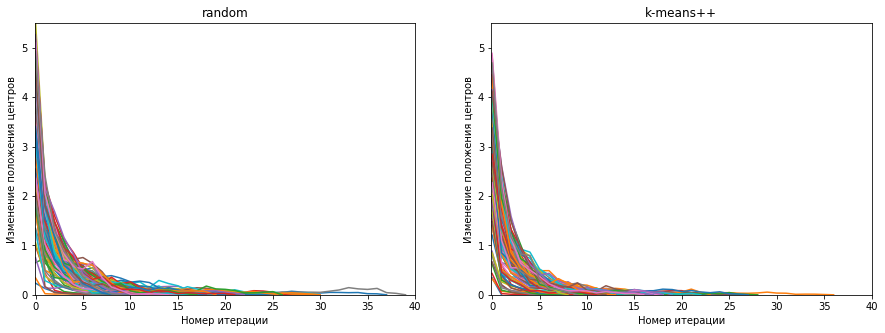

In [1445]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.set_figheight(5)
fig.set_figwidth(15)

n_clusters = np.arange(2, 100)

for n in n_clusters:
    X = make_blobs(1000, n)
    clf = MyKMeans(n_clusters=n, init="random")
    dif = clf.fit_predict(X)[3]
    ax1.set_title('random')
    ax1.set_ylabel('Изменение положения центров')
    ax1.set_xlabel('Номер итерации')
    ax1.axis([-0.1, 40, 0, 5.5])
    ax1.plot(range(len(dif)), dif)
    
for n in n_clusters:
    X = make_blobs(1000, n)
    clf = MyKMeans(n_clusters=n, init="k-means++")
    dif = clf.fit_predict(X)[3]
    ax2.set_title('k-means++')
    ax2.set_ylabel('Изменение положения центров')
    ax2.set_xlabel('Номер итерации')
    ax2.axis([-0.1, 40, 0, 5.5])
    ax2.plot(range(len(dif)), dif)

Из графиков видно, что при обеих стратегиях начальной инициализации алгоритм сходится. Причём хочется отметить, что при использовании стратегии k-means++ графики более плавные, меньше сильных скачков вверх, которые наблюдаются при случайном выборе начальных центров, что является подтверждением того, что k-means++ является более стабильным. Также уже из этих графиков можно заметить некоторое уменьшение числа итераций до сходимости.

In [1447]:
n_clusters = np.arange(2, 50)
mean = np.zeros(20)

arr_random = np.zeros(n_clusters.size)

for n in n_clusters:
    for i in range(20):
        X = make_blobs(1000, n)
        clf = MyKMeans(n_clusters=n, init="random")
        mean[i] = clf.fit_predict(X)[1]
    arr_random[n - 2] = mean.mean()

In [1448]:
arr_kmeans = np.zeros(n_clusters.size)

for n in n_clusters:
    for i in range(20):
        X = make_blobs(1000, n)    
        clf = MyKMeans(n_clusters=n, init="k-means++")
        mean[i] = clf.fit_predict(X)[1]
    arr_kmeans[n - 2] = mean.mean()

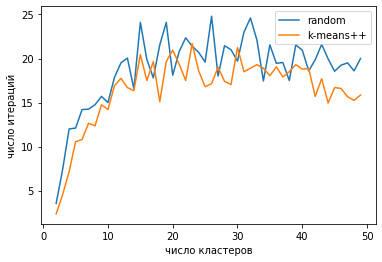

In [1449]:
plt.xlabel("число кластеров")
plt.ylabel("число итераций")
plt.plot(n_clusters, arr_random, label="random")
plt.plot(n_clusters, arr_kmeans, label="k-means++")
plt.legend()
fig.set_figwidth(30)
fig.set_figheight(30)

Действительно, при использовании стратегии k-means++ число итераций до сходимости несколько уменьшается.

## Применимость алгоритма k-means

Алгоритм k-means способен выявлять только кластеры шарообразной формы, простые скопления объектов в некоторой области, для поиска кластеров более сложной формы он не приспособлен. Желательно знать количество кластеров, на которое мы хотим разбить выборку, так как хотя есть различные способы выбрать лучшее разбиение, они все не идельны и допускают ошибки. 

## Стратегия выбора числа кластеров

Если число кластеров заранее неизвестно, можно попробовать разбить выборку на различное число кластеров и посмотреть какое из разбиений лучше.Для этого нужно иметь некоторую функцию, по значению которой можно будет понять какое из разбиений лучше, так называемый функционал качества.

Выбирая такой функционал в своем алгоритме я руководствовался несколькими разумными требованиями к желаемому разбиению.
    1) Элементы внутри одного кластера должны быть "похожи", находится на небольшом расстоянии.
    2) Элементы относящиеся к разным кластерам должны быть различны, находиться на большом расстоянии.
    
Переводя на математический язык, я хочу минимизировать внутрикластерное расстояние для каждого кластера и максимизировать межкластерное расстояние.

Для минимизации внутрикластерного расстояния буду минимизировать сумму средних внутрикластерных расстояний по всем кластерам:

$$Q_1 = \sum\limits_{c \in C} \frac{1}{\mid S_c\mid} \sum\limits_{x_{i} \in c} \rho^{2}(x_{i}, \mu_{c})$$

$C ~-$ множество кластеров, $|S_c| ~-$ число элементов в одном кластере, $\mu_{c} ~-$ центр кластера $c$.

Для максимизации межкластерного расстояния буду максимизировать среднее межкластерное расстояние:
    
$$Q_2 = \frac{1}{\mid C \mid}\sum\limits_{c \in C}\rho^{2}(\mu_c, \mu)$$

$\mu ~-$ центр всей выборки.

В качестве итогового функционала качества возьму следующую функцию:

$$Q = \frac{Q_1}{Q_2}$$

Этот функционал и буду минимизировать при поиске оптимального числа кластеров.

Протестирую данную стратегию поиска числа кластеро на обоих генераторах.

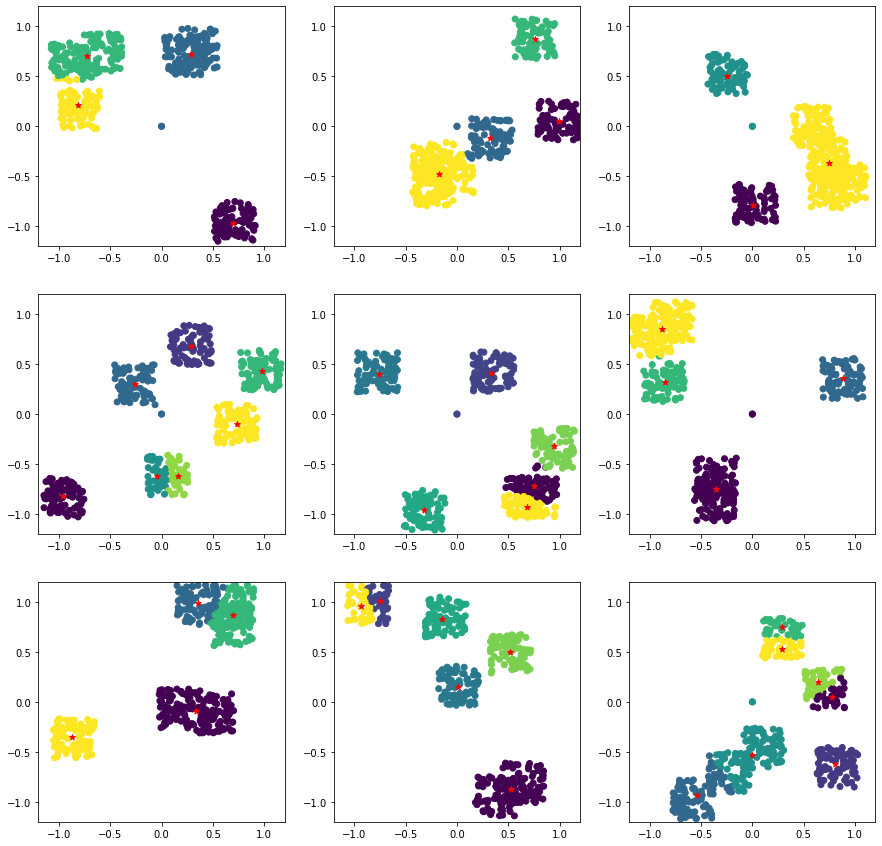

In [1534]:
fig = plt.figure()
ax1 = fig.add_subplot(331)
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333)
ax4 = fig.add_subplot(334)
ax5 = fig.add_subplot(335)
ax6 = fig.add_subplot(336)
ax7 = fig.add_subplot(337)
ax8 = fig.add_subplot(338)
ax9 = fig.add_subplot(339)
fig.set_figheight(15)
fig.set_figwidth(15)

ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
clf = MyKMeans(n_clusters = 0, init = "k-means++")
for a in ax:
    X = make_blobs(500, 6)
    pred = clf.fit_predict(X)
    a.scatter(X[:,0], X[:,1], c=pred[0])
    a.axis([-1.2, 1.2, -1.2, 1.2])
    a.scatter(pred[4][:,0], pred[4][:,1], marker = '*', c='r')

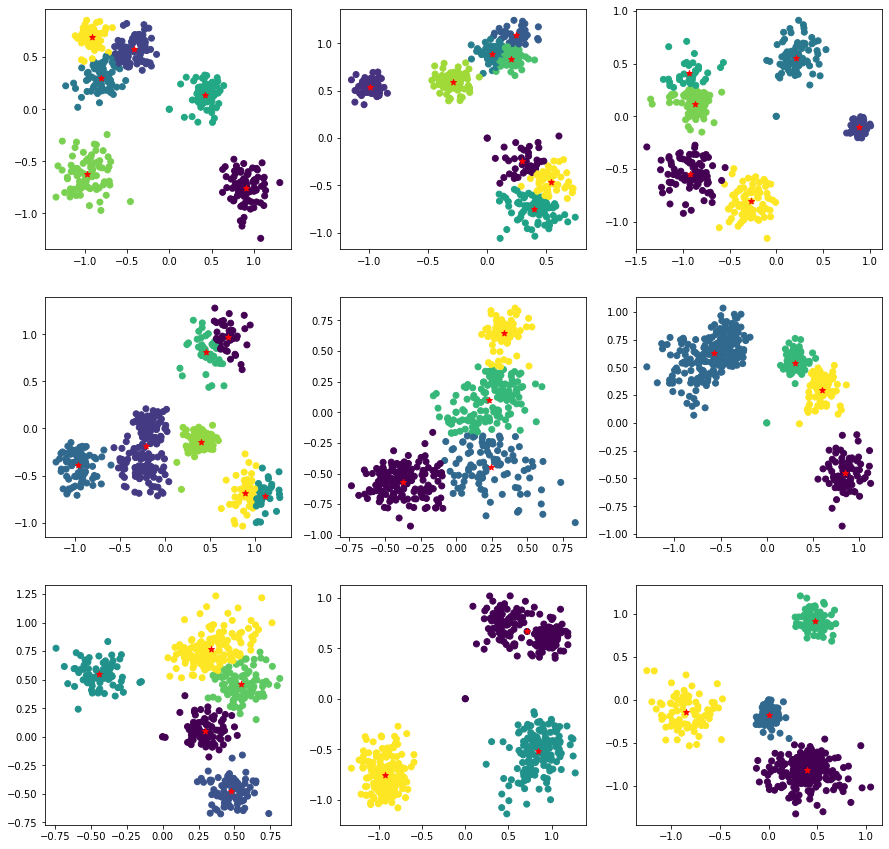

In [1455]:
fig = plt.figure()
ax1 = fig.add_subplot(331)
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333)
ax4 = fig.add_subplot(334)
ax5 = fig.add_subplot(335)
ax6 = fig.add_subplot(336)
ax7 = fig.add_subplot(337)
ax8 = fig.add_subplot(338)
ax9 = fig.add_subplot(339)
fig.set_figheight(15)
fig.set_figwidth(15)

ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
clf = MyKMeans(n_clusters = 0, init = "k-means++")
for a in ax:
    X = generate_gauss(500, 6)
    pred = clf.fit_predict(X)
    a.scatter(X[:,0], X[:,1], c=pred[0])
    a.scatter(pred[4][:,0], pred[4][:,1], marker = '*', c='r')

## Визуализация кластеризации с помощью матрицы попарных расстояний

Качество кластеризации удобно визуализировать с помощью матрицы попарных расстояний, сгруппировав объекты по кластерам. 
Ниже это реализовано и протестировано.

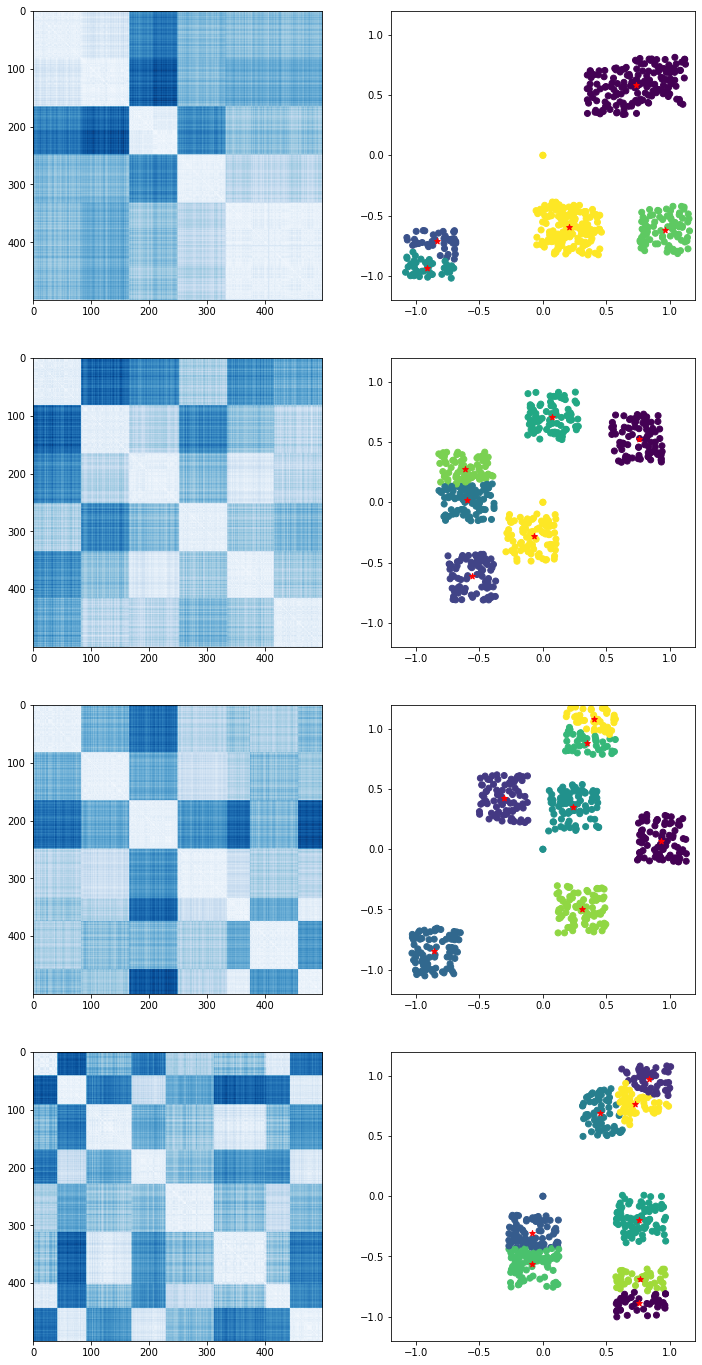

In [1524]:
fig = plt.figure()
ax1 = fig.add_subplot(8, 2, 1)
ax2 = fig.add_subplot(8, 2, 2)
ax3 = fig.add_subplot(8, 2, 3)
ax4 = fig.add_subplot(8, 2, 4)
ax5 = fig.add_subplot(8, 2, 5)
ax6 = fig.add_subplot(8, 2, 6)
ax7 = fig.add_subplot(8, 2, 7)
ax8 = fig.add_subplot(8, 2, 8)
fig.set_figheight(50)
fig.set_figwidth(12)

ax = [(ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)]
clf = MyKMeans(n_clusters=0, init='k-means++')

for a in ax:
    X = make_blobs(500, 6)
    pred = clf.fit_predict(X)
    arg = np.argsort(pred[0])
    Dist = distance.cdist(X[arg], X[arg])
    a[0].imshow(Dist, cmap="Blues")
    a[1].axis([-1.2, 1.2, -1.2, 1.2])
    a[1].scatter(X[:,0], X[:,1], c=pred[0])
    a[1].scatter(pred[4][:,0], pred[4][:,1], marker = '*', c='r')


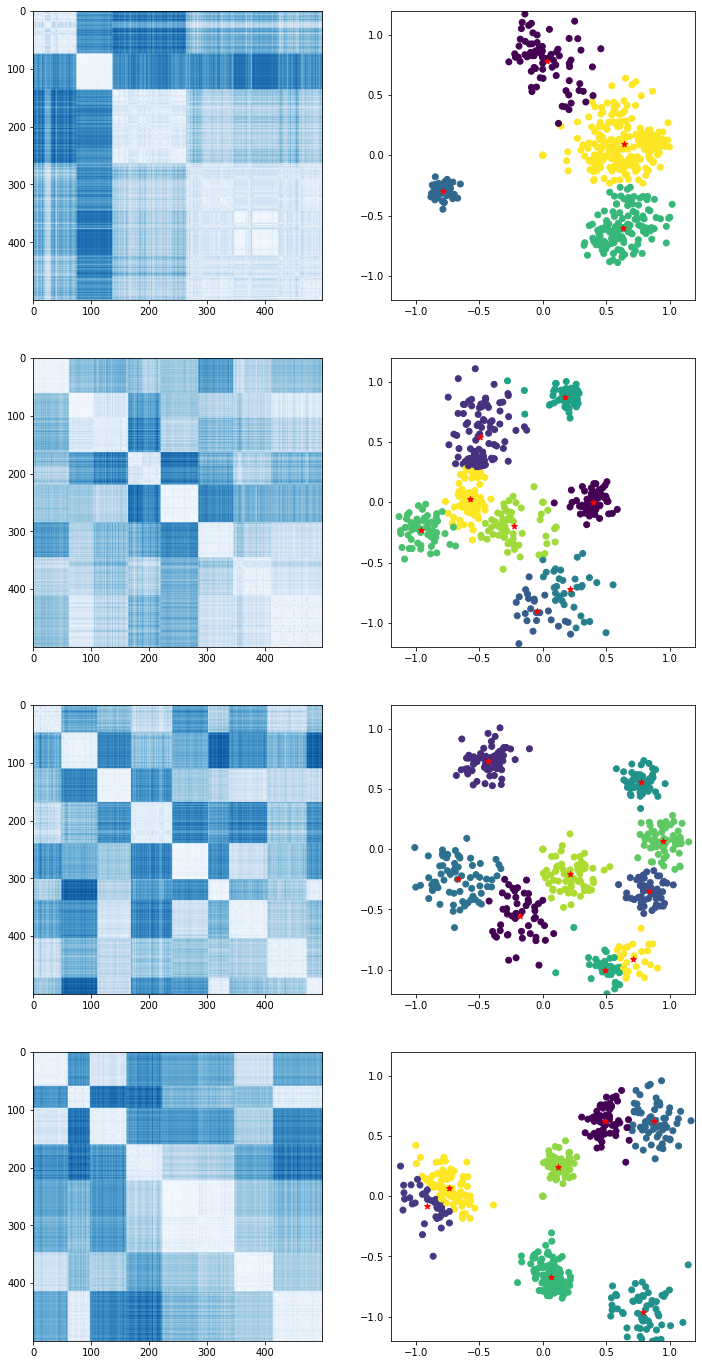

In [1516]:
fig = plt.figure()
ax1 = fig.add_subplot(8, 2, 1)
ax2 = fig.add_subplot(8, 2, 2)
ax3 = fig.add_subplot(8, 2, 3)
ax4 = fig.add_subplot(8, 2, 4)
ax5 = fig.add_subplot(8, 2, 5)
ax6 = fig.add_subplot(8, 2, 6)
ax7 = fig.add_subplot(8, 2, 7)
ax8 = fig.add_subplot(8, 2, 8)
fig.set_figheight(50)
fig.set_figwidth(12)

ax = [(ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)]
clf = MyKMeans(n_clusters=0, init='k-means++')

for a in ax:
    X = generate_gauss(500, 8)
    pred = clf.fit_predict(X)
    arg = np.argsort(pred[0])
    Dist = distance.cdist(X[arg], X[arg])
    a[0].imshow(Dist, cmap="Blues")
    a[1].axis([-1.2, 1.2, -1.2, 1.2])
    a[1].scatter(X[:,0], X[:,1], c=pred[0])
    a[1].scatter(pred[4][:,0], pred[4][:,1], marker = '*', c='r')